In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import f_regression
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LogisticRegression

#import seaborn as sns
#sns.set(style = 'white')

In [47]:
#load data

#pitches_orig = pd.read_csv('pitches.csv')
#at_bat = pd.read_csv('atbats.csv')

Data Description:
---
Our data is from a Kaggle competition: https://www.kaggle.com/pschale/mlb-pitch-data-20152018

The data consists of pitch information from 2015-2018 and originally consists of 2.87 million observations and 40 columns, 1 column is the response and leaves 39 possible predictors. We aim to predict on the pithces swung at, whether or not the ball was put in play or not, which is a binary classification problem at its core.

After some data investigating we were left with 10 predictors listed below. We choose these predictor since they were the most interpretable. After understanding each of these predictors, we made some decisions on the data our model would ingest. For example, `p_x` is one of our predictors and looks at the location of the ball relative to the sides of home plate. This `p_x` is hard to interpret for left handed vs right handed batters, so we only included right handed at bats since those were ___ % of the at bats. Additionally, we only looked at plays where the batter swung the bat and the ball was hit in play or missed completley. Finally, we narrowed our data set down to only fastballs, two seam and four seam, and encoded a dummy variable accordingly.

Our model data set was ___ number of rows and 10 columns for the X matrix. There were ___ swinging strikes and ___ in play balls, ___ % and ___ % of the entire data set respectivley.


* **response** is swinging strike or ball put in play - a binary variable
    * X - In play, out(s)
    * D - In play, no out
    * E - In play, runs
    * S - Swinging Strike

Predictors

* only doing four seam and two seam fastball:
    * pitch_type: FF and FT
* p_x: x-location as pitch crosses the plate. X=0 means right down the middle
* p_z:z-location as pitch crosses the plate. Z=0 means the ground
* start_speed: Speed of the pitch just as it's thrown
* end_speed: Speed of the pitch when it reaches the plate #linear wtih start speed
* spin_rate: the pitch's spin rate, measure in RPM
* spin_dir: Direction in which pitch is spinning, measured in degrees
* break_angle: 
* break_length: 
* break_y

Statement of the research problems, and a summary of methods​ included in the
report.

Problem statement 

In [48]:
pitches_orig.head(2)

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,...,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,...,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0


In [49]:
at_bat_right_hand.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
6,2015000007,624585,Groundout,201500001,1,1,1,R,425794,R,False
8,2015000009,516770,Groundout,201500001,1,3,1,R,425794,R,False
9,2015000010,425877,Strikeout,201500001,2,1,0,L,452657,R,True


In [12]:
pitches_orig.loc[(pitches_orig.code.isin(['X', 'D', 'E', 'S'])) & (pitches_orig.pitch_type.isin(['FT']))].shape[0]

90379

In [9]:
pitches_orig.loc[pitches_orig.code.isin(['S'])].shape[0]/(pitches_orig.loc[pitches_orig.code.isin(['S'])].shape[0] + pitches_orig.loc[pitches_orig.code.isin(['X', 'D', 'E'])].shape[0])

0.3463076934858467

full data clean
---

In [51]:
at_bat_right_hand = at_bat.loc[at_bat.stand == 'R']
pitches_orig = pd.merge(pitches_orig, at_bat_right_hand, how = 'inner', right_on = 'ab_id', left_on = 'ab_id')
pitches_orig = pitches_orig.loc[(pitches_orig.code.isin(['X', 'D', 'E', 'S'])) & (pitches_orig.pitch_type.isin(['FT', 'FF']))]
pitches_orig.loc[pitches_orig.code.isin(['X', 'D', 'E']), 'in_play_boolean'] = int(1)
pitches_orig.loc[pitches_orig.code.isin(['S']), 'in_play_boolean'] = int(0)
model_df = pitches_orig[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'pitch_type','in_play_boolean']]
#dummies
pitch_typed = pd.get_dummies(model_df['pitch_type'])
#cat_list = pd.get_dummies(model_df['pitch_type'], prefix=var)
model_df = pd.concat([model_df, pitch_typed], axis=1)
#data=data1

In [55]:
#dummies
pitch_typed = pd.get_dummies(model_df['pitch_type'])
#cat_list = pd.get_dummies(model_df['pitch_type'], prefix=var)
model_df = pd.concat([model_df, pitch_typed], axis=1)
#data=data1

In [75]:
model_df.groupby('in_play_boolean').mean()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,FF,FT
in_play_boolean,,,,,,,,,,,
0.0,0.054367,2.843619,93.289811,85.434176,2187.806680,189.528325,7.844791,4.166422,23.791840,0.815159,0.184841
1.0,-0.068884,2.496959,92.548382,85.048025,2140.783382,191.174323,9.193090,4.641281,23.799423,0.706511,0.293489


In [73]:
features = model_df[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'FF', 'FT']]
X = sm.add_constant(features)

/Users/rushilsheth/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [70]:
model_df.shape[0]

201076

In [77]:
X.head()

,const,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,FF,FT
2,1.0,-0.286,1.830,92.6,84.4,2475.323,137.145,-39.0,4.8,23.7,1,0
17,1.0,1.253,2.260,91.4,83.5,2597.251,156.275,-36.5,3.3,23.7,1,0
32,1.0,0.487,2.332,89.2,81.8,1675.017,190.160,5.3,4.5,23.8,1,0
54,1.0,0.056,3.286,89.2,80.9,2309.073,150.668,-29.9,4.1,23.7,1,0
57,1.0,0.140,1.891,90.7,82.7,2161.347,147.950,-27.8,4.4,23.7,1,0


In [79]:
import statsmodels.api as sm
logit_model=sm.Logit(model_df[['in_play_boolean']],X[['const', 'spin_rate', 'break_angle']])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.602414
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.003      
Dependent Variable: in_play_boolean  AIC:              242268.0306
Date:               2019-10-05 15:16 BIC:              242298.6649
No. Observations:   201076           Log-Likelihood:   -1.2113e+05
Df Model:           2                LL-Null:          -1.2146e+05
Df Residuals:       201073           LLR p-value:      4.0800e-142
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const          1.4906    0.0269   55.4993  0.0000   1.4379   1.5432
spin_rate     -0.0003    0.0000  -23.5837  0.0000

EDA
---

TypeError: can only concatenate str (not "float") to str

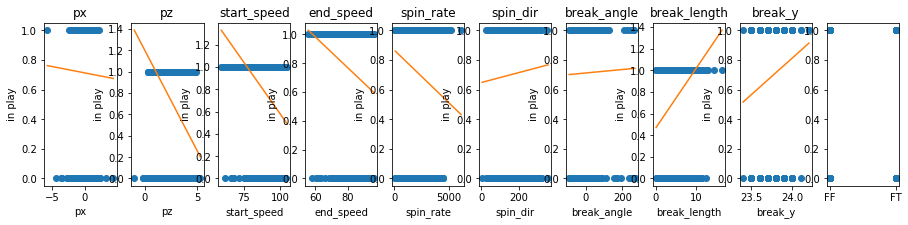

In [37]:
#scatter plot
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))

# i: index
for i, col in enumerate(features.columns):
    plt.subplot(1, 13, i+1)
    x = features[col]
    y = model_df.in_play_boolean
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('in play')

In [39]:
model_df['in_play_boolean'].value_counts()

1.0    244747
0.0     98509
Name: in_play_boolean, dtype: int64

In [40]:
model_df.groupby('in_play_boolean').mean()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y
in_play_boolean,,,,,,,,,
0.0,-0.052575,2.845445,93.313996,85.450735,2189.556934,193.688385,11.999671,4.196711,23.791857
1.0,-0.066424,2.481995,92.598559,85.101599,2131.829892,195.829443,12.439588,4.630540,23.799906


In [41]:
cat_list = pd.get_dummies(model_df['pitch_type'], prefix=var)
model_df=model_df.join(cat_list)
#data=data1

NameError: name 'var' is not defined